In this notebook, we take a look at response-time-related variables, such as mouse- and eye-response initation times, and difference between those, termed initial decision (ID) lag.

# Table of Contents
1. [Preparing the data and plots](#preparing)
2. [Mouse initiation time](#mouse_IT)
    * [CoM differences](#mouse_IT_CoM)
3. [Eye initiation time](#eye_IT)
    * [CoM differences](#eye_IT_CoM)
4. [Hand-eye lag at initial decision](#ID_lag)

<a name="preparing"></a>
# Preparing data and plots
First, we set up visuals and read the data.

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import display, HTML
import warnings
warnings.filterwarnings('ignore')

#set precision for displaying float-point values in the notebook
pd.options.display.float_format = '{:,.3f}'.format

#set figure dpi to 100 to get reasonably sized figures displayed in the notebook
plt.rc('figure', dpi=100)

#set savefig dpi to 300 to get high-quality images to insert in the paper
plt.rc('savefig', dpi=300)

#set to 'pdf' or 'eps' for vector figures or to 'png'
plt.rc('savefig', format='png')

#set font sizes for figures throughout
plt.rc('xtick', labelsize=16)
plt.rc('ytick', labelsize=16)
plt.rc('axes', labelsize=20, titlesize=22)
plt.rc('legend', fontsize=18)

palette = sns.color_palette()
scale = 1.0

In [2]:
import data_reader
dr = data_reader.DataReader()

# if Exp1 and Exp2 data need to be plotted alongside each other, read those data into separate dataframes
exp_1, exp_2 = 'exp_1', 'exp_2'
choices_1, dynamics_1, stim_viewing_1 = dr.get_data(path='../../data/HEM_%s/processed/' % (exp_1), stim_viewing=True)
choices_2, dynamics_2, stim_viewing_2 = dr.get_data(path='../../data/HEM_%s/processed/' % (exp_2), stim_viewing=True)

We have to drop infinite eye initation times. This happens when eye does not move from the center of the screen (or one of the response areas) throughout the trial.

In [3]:
def discard_inf_eye_IT_trials(choices):
    to_discard = (abs(choices['eye_IT']) == np.inf)
    choices = choices[~to_discard]
    print('%i trials discarded due to no movements' % (to_discard.sum()))
    return choices

choices_1 = discard_inf_eye_IT_trials(choices_1)
choices_2 = discard_inf_eye_IT_trials(choices_2)

1 trials discarded due to no movements
155 trials discarded due to no movements


Next we have a function which will plot individual- and group-level mean values of response-time-related variables for each coherence level.

In [4]:
import matplotlib.lines as mlines

def plot_var_vs_coherence(choices, exp, var):    
    subj_order = sorted(choices.subj_id.unique())
    
    plt.figure()
    
    ax = sns.pointplot(data=choices[(choices.is_correct) & (choices.coherence>0)], 
                       x='coherence', y=var, hue='subj_id', 
                       palette=palette, scale=scale, errwidth=0.5, 
                       join=False, dodge=True, capsize=.2, hue_order=subj_order)
    
    ax = sns.pointplot(data=choices[(~choices.is_correct) & (choices.coherence>0)], 
                       x='coherence', y=var, hue='subj_id', 
                       palette=palette, linestyles=['--', '--', '--', '--'], 
                       markers=['x', 'x', 'x', 'x'], scale=scale, 
                       errwidth=0.5, dodge=True, capsize=.2, join=False, 
                       hue_order=subj_order, ax=ax)

    ax = sns.pointplot(data=choices[(choices.coherence>0) & (~choices.is_correct)], 
                       x='coherence', y=var, linestyles=['--'], color='grey',
                       markers=['x'], scale=scale, errwidth=0.5, ax=ax)
    
    ax = sns.pointplot(data=choices[(choices.coherence>0) & (choices.is_correct)],
                       x='coherence', y=var, linestyles=['-'], color='grey', 
                       scale=scale, errwidth=0.5, ax=ax)


#     ax.set_ylim([0, 1.2])      
    ax.set_xlabel('Coherence')
    ax.set_ylabel(var)
    
    ax.legend_.remove()
    correct_line = mlines.Line2D([], [], color='grey', marker='o', lw=3.0, label='Correct trials')
    error_line = mlines.Line2D([], [], color='grey', marker='x', ls='--', lw=3.0, label='Error trials')
    plt.legend(handles=[correct_line, error_line])
    plt.title(exp)
    plt.tight_layout()
    plt.savefig('figures/%s_vs_coherence_ind_%s' % (var, exp))

<a name="mouse_IT"></a>
# Mouse initation time

First, we plot IT distributions for both experiments. Note that IT for both mouse and eye can be negative, as premature responses during stimulus presentations are factored in during pre-processing.

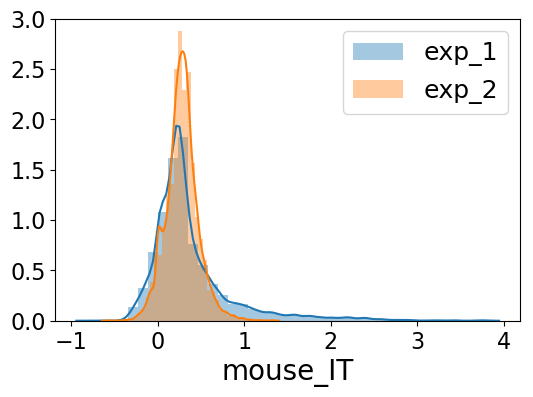

In [5]:
sns.distplot(choices_1.mouse_IT, bins=40, label=exp_1)
sns.distplot(choices_2.mouse_IT, bins=40, label=exp_2)
plt.gca().set_ylim(0, 3)
plt.legend()

In Exp 2, the distibution is narrower, indicating that our manipulation (penalties for premature and late responses) works.

Now, let's look at mouse initation times for each coherence level

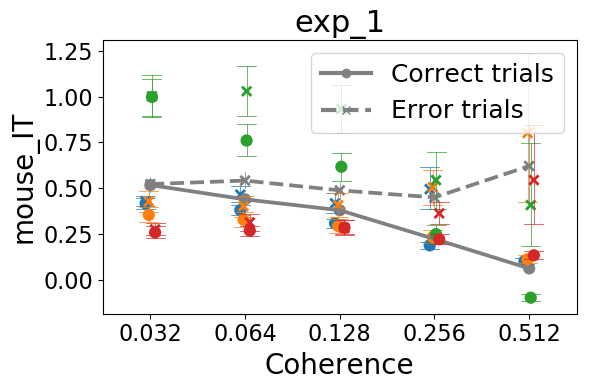

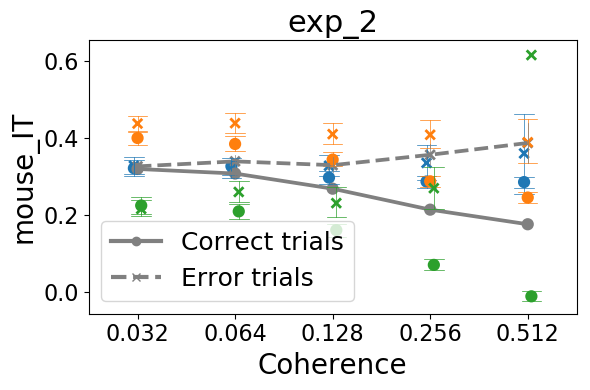

In [6]:
plot_var_vs_coherence(choices_1, exp_1, var='mouse_IT')
plot_var_vs_coherence(choices_2, exp_2, var='mouse_IT')

Pretty much what we expect: for all subjects (except for the green subject in Exp 1), mouse IT decreases with coherence for correct trials, and remains more-less constant or even increases for error trials __(the '<' pattern)__. Notably, the '<' pattern is way less pronounced in blue participant in Exp 2.

<a name="mouse_IT_CoM"></a>
## CoM differences

Taking into account individual differences in initiation times, it is useful to account for those when looking into initiation times for CoM and non-CoM trials. Here we have to look at z-scored initiation times though, to get general patterns.

These plotting functions are used for both mouse and eye IT data analysis

In [7]:
def plot_var_norm_individual_by_is_com(choices, exp, var):
    ax = sns.factorplot(data=choices[choices.coherence>0], x='coherence', y=var, 
                        col='is_com', row='subj_id', hue='is_correct', capsize=.2, errwidth=0.5)
    plt.subplots_adjust(top=0.9)
    plt.suptitle(exp, fontsize=30)

def plot_var_norm_by_is_com(choices, exp, var):
    ax = sns.factorplot(data=choices[choices.coherence>0], x='coherence', y=var, 
                   col='is_com', hue='is_correct', capsize=.2, errwidth=0.5)
    plt.subplots_adjust(top=0.8)
    plt.suptitle(exp, fontsize=30)

After we accounted for magnitude of within-individual initiation times, we can see how relative magnitude of initiation time changes with coherence in non-CoM and CoM trials:

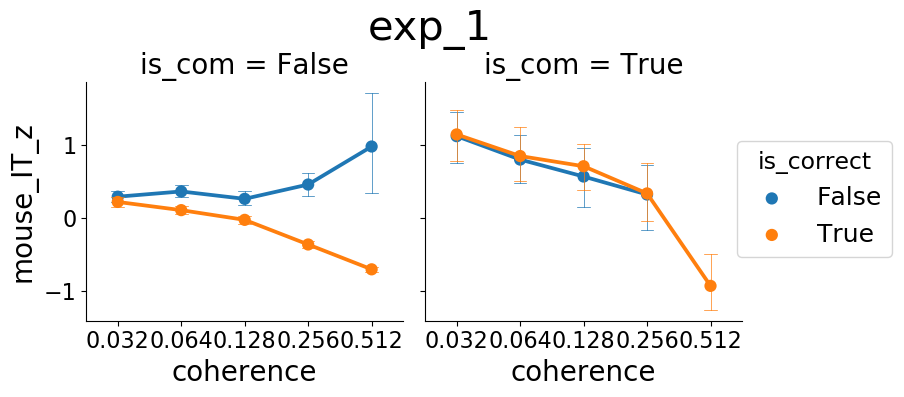

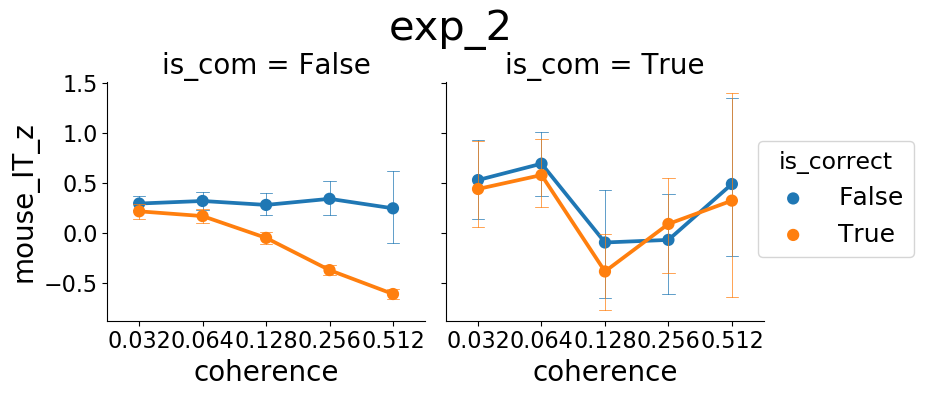

In [8]:
# choices_1['subj_id'] = choices_1.index.get_level_values('subj_id')
# plot_var_norm_by_is_com(choices_1[~(choices_1.subj_id==391)], exp_1, var='mouse_IT_z')
plot_var_norm_by_is_com(choices_1, exp_1, var='mouse_IT_z')
plot_var_norm_by_is_com(choices_2, exp_2, var='mouse_IT_z')

Surprisingly, in CoM trials participants exhibit identical relative initiation times in correct and error trials! This was observed in both experiments. How can we interpret this? Let's see if the individual patterns differ:

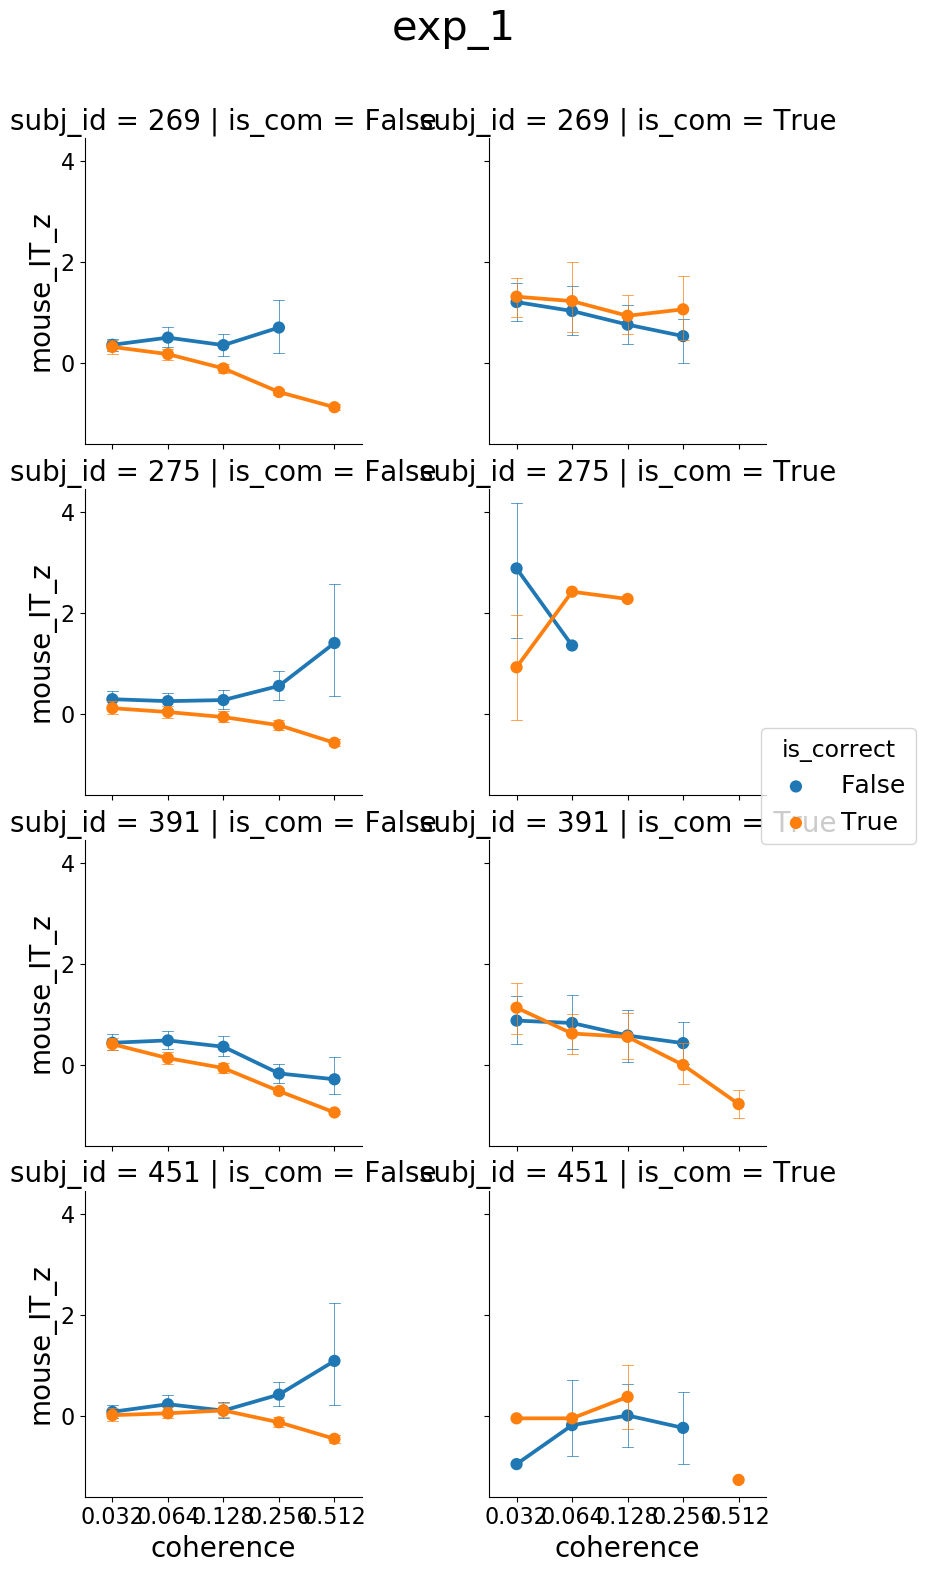

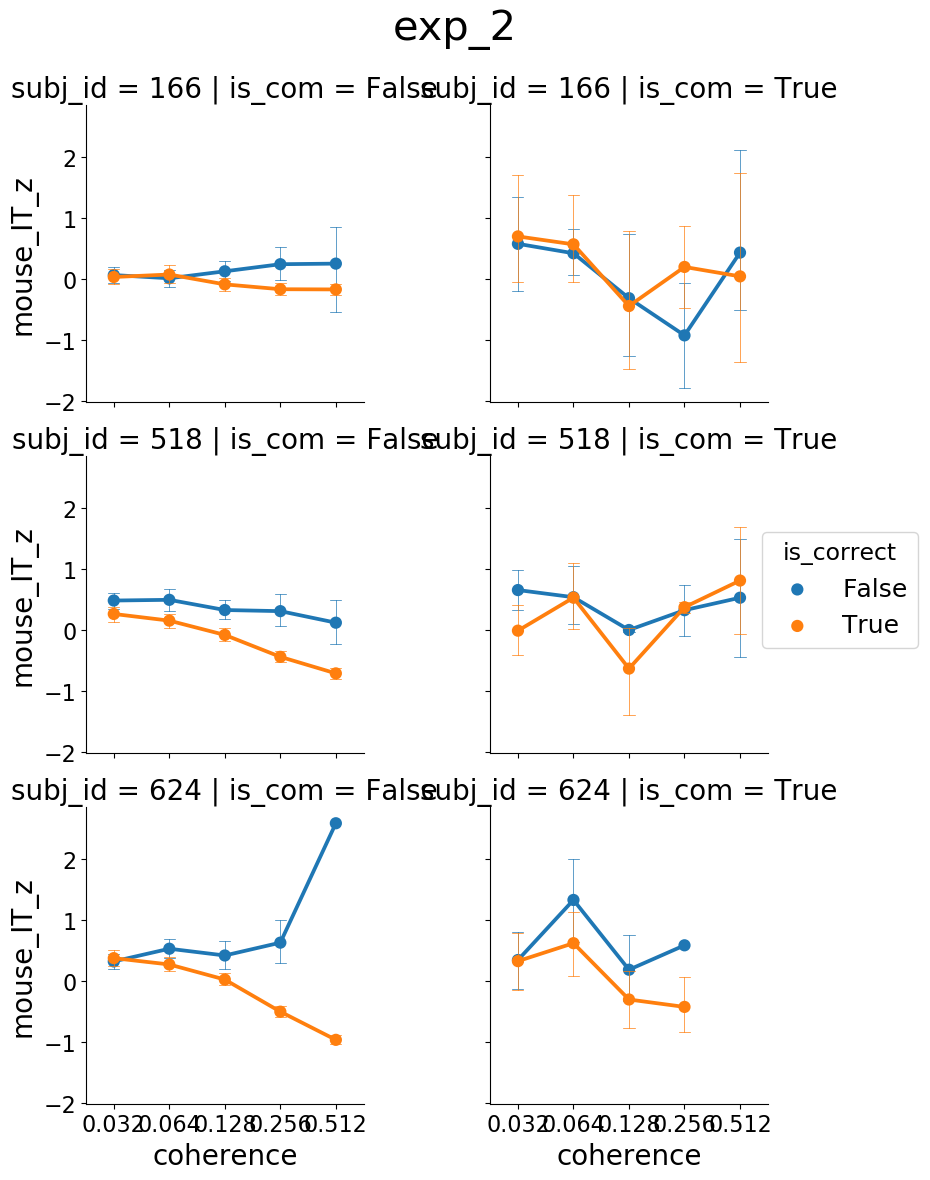

In [9]:
# Uncomment this to see same plots for each participant (beware there is little data in each condition then)
plot_var_norm_individual_by_is_com(choices_1, exp_1, var='mouse_IT_z')
plot_var_norm_individual_by_is_com(choices_2, exp_2, var='mouse_IT_z')

<a name="eye_IT"></a>
# Eye initation time

Next, we look at eye latencies (termed eye initiation time for consistency)

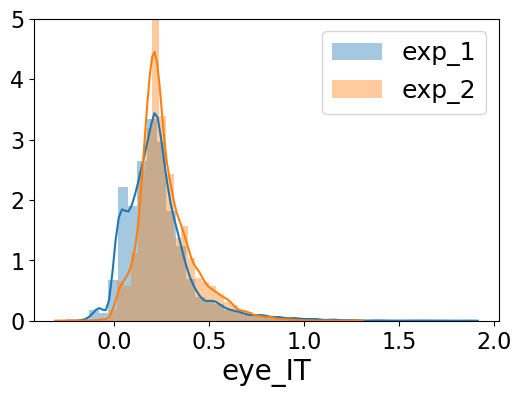

In [10]:
sns.distplot(choices_1.eye_IT, bins=40, label=exp_1)
sns.distplot(choices_2.eye_IT, bins=40, label=exp_2)
plt.gca().set_ylim(0, 5)
plt.legend()

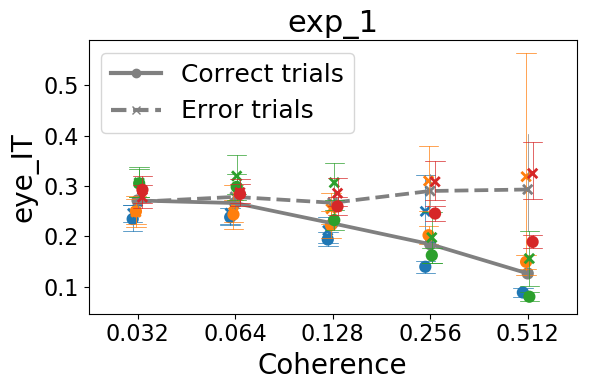

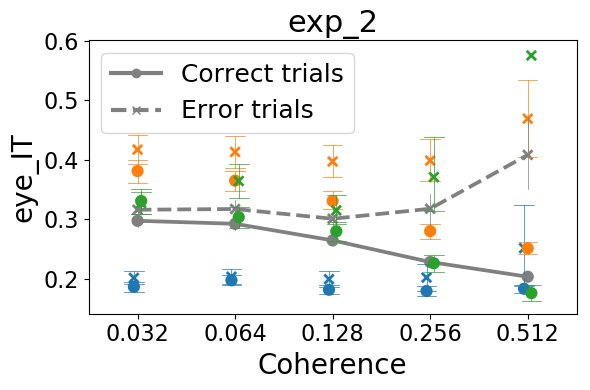

In [11]:
plot_var_vs_coherence(choices_1, exp_1, var='eye_IT')
plot_var_vs_coherence(choices_2, exp_2, var='eye_IT')

The overall pattern is very similar to mouse IT. In Exp 1, there are basically no individual differences. In Exp 2, the blue participant had very low eye IT for all coherence level and correct/error trials, but the < pattern still seems to be there.

<a name="eye_IT_CoM"></a>
## CoM differences

Based on differences in correct/error mouse_IT pattern between CoM and non-CoM trials, one would expect similar difference in eye initiation times as well (given that in general, eye IT follows the same '<' pattern). Let's see if this is actually the case:

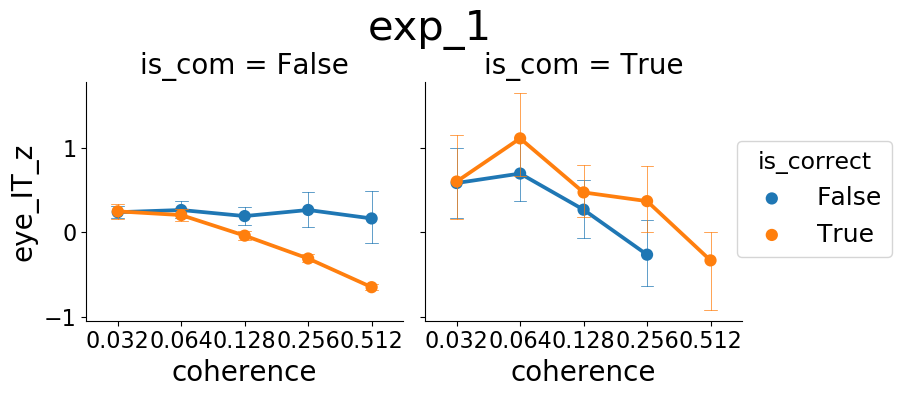

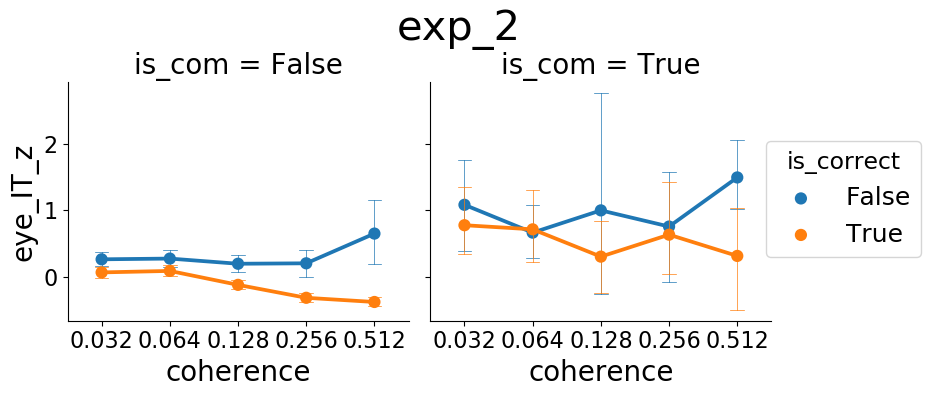

In [13]:
plot_var_norm_by_is_com(choices_1, exp_1, var='eye_IT_z')
plot_var_norm_by_is_com(choices_2, exp_2, var='eye_IT_z')

It turns out that we can actually see the difference between correct and error CoM trials in eye initiation times! But we have just seen that this is not the case in mouse IT... Why is that so?

Strangely, though, in Exp 1 correct CoM's had slower eye initiation than error CoM, but this was reversed in Exp 2. Is it due to experimental manipulation or individual differences? 

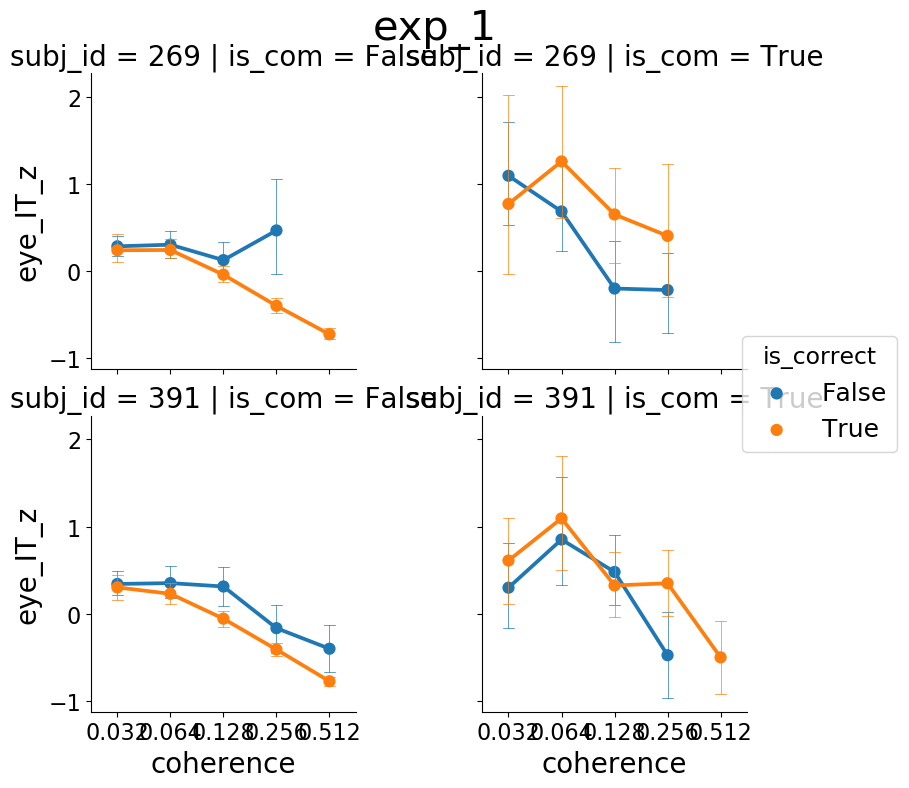

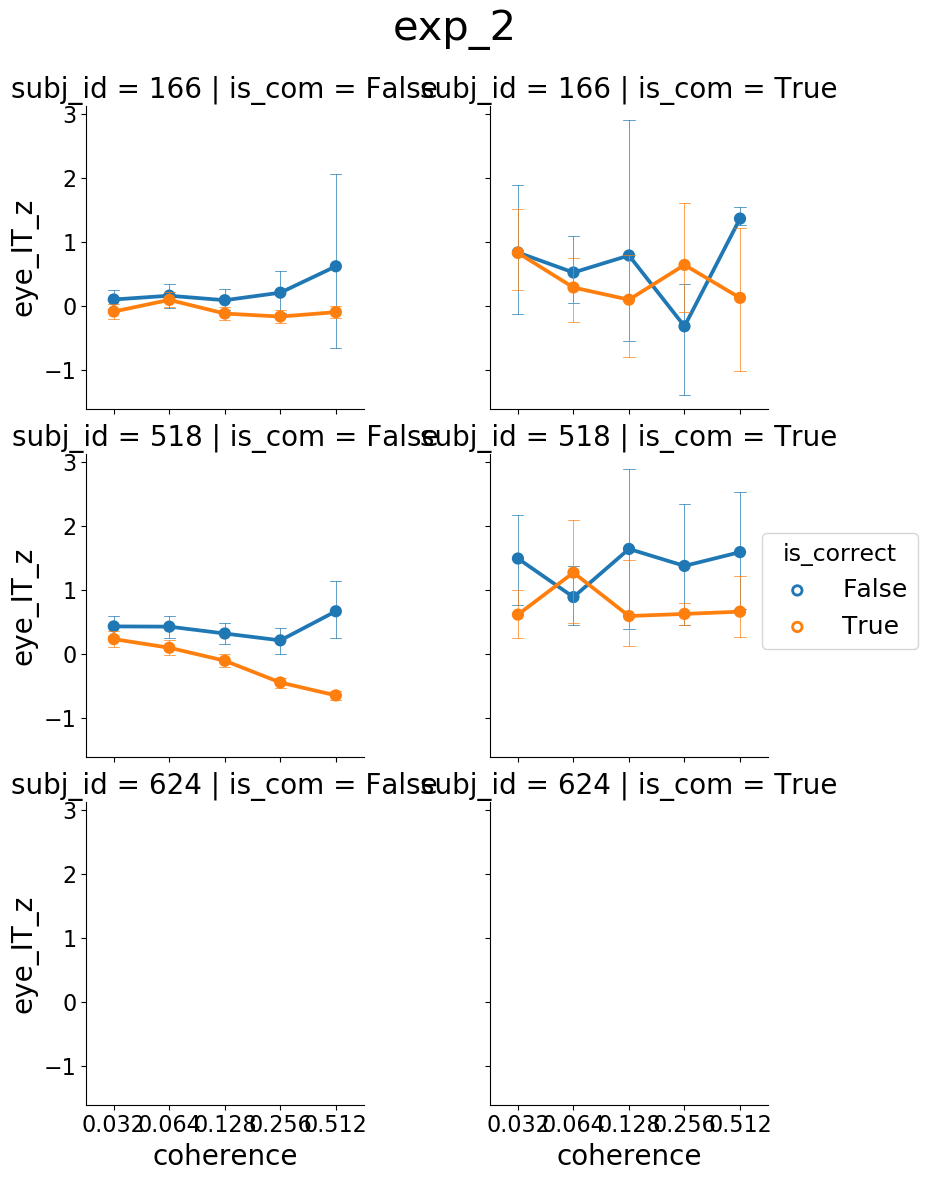

In [15]:
# Uncomment this to see same plots for each participant (beware there is little data in each condition then)
plot_var_norm_individual_by_is_com(choices_1[(choices_1.subj_id == 269) | (choices_1.subj_id == 391)], exp_1, var='eye_IT_z')
plot_var_norm_individual_by_is_com(choices_2, exp_2, var='eye_IT_z')

<a name="ID_lag"></a>
# Hand-eye lag at initial decision
Now, let's look at the hand-eye lag at initial decision:
>ID_lag = mouse_IT - eye_IT

Interestingly, ID lag is highly (0.93) correlated with mouse IT in Exp 1 (correlation is weaker in Exp 2, around 0.67). However, z-scores of ID lag and mouse_IT correlate only with 0.5 in both experiments.

In [17]:
choices_1['ID_lag_z'] = choices_1.eye_IT.groupby(level='subj_id').apply(lambda c: (c-np.nanmean(c))/np.nanstd(c))
choices_2['ID_lag_z'] = choices_2.eye_IT.groupby(level='subj_id').apply(lambda c: (c-np.nanmean(c))/np.nanstd(c))

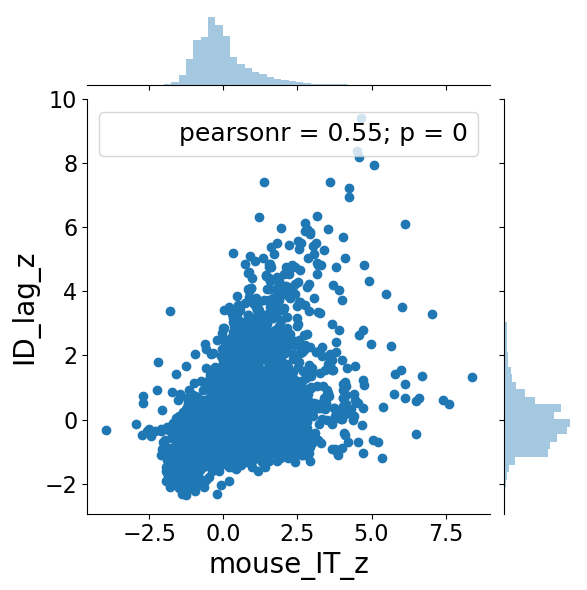

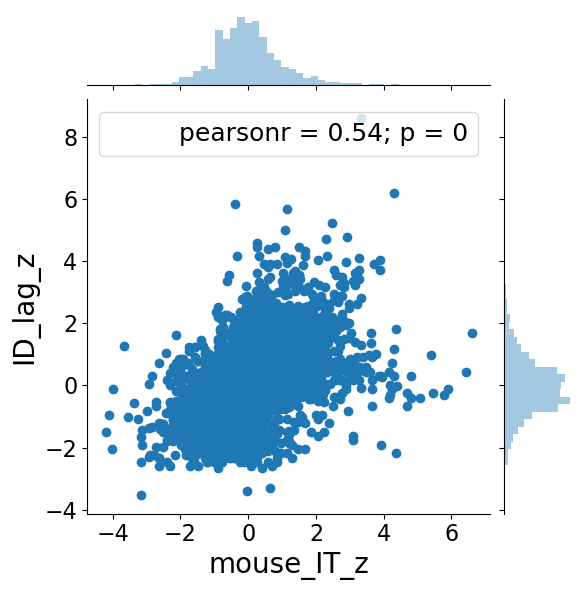

In [19]:
sns.jointplot(data=choices_1, x='mouse_IT_z', y='ID_lag_z')
sns.jointplot(data=choices_2, x='mouse_IT_z', y='ID_lag_z')

Consequently, in Exp 1, ID lag basically follows mouse IT, with the green participant having substantially larger lag than the others due to late mouse movements.

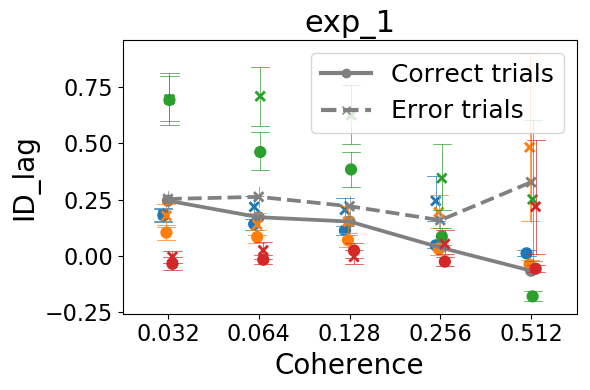

In [21]:
plot_var_vs_coherence(choices_1, exp_1, var='ID_lag')

However, if we account for individual differences in scale of the lag, the general pattern becomes clear

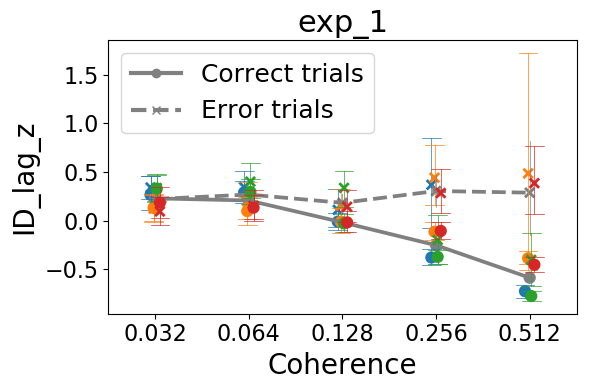

In [20]:
plot_var_vs_coherence(choices_1, exp_1, var='ID_lag_z')

It seems there is lots of individual variability in the lag, which we didn't notice previously. Let's look closer at individual-level lags in Exp 1

""


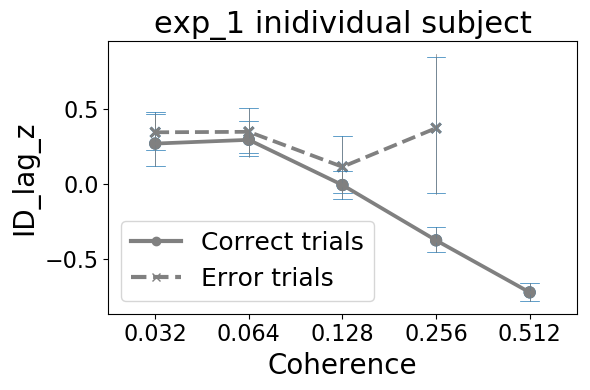

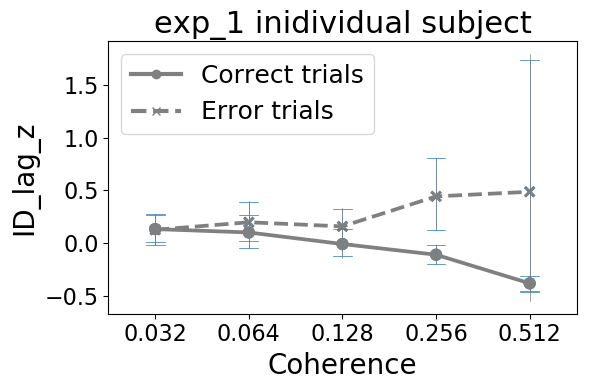

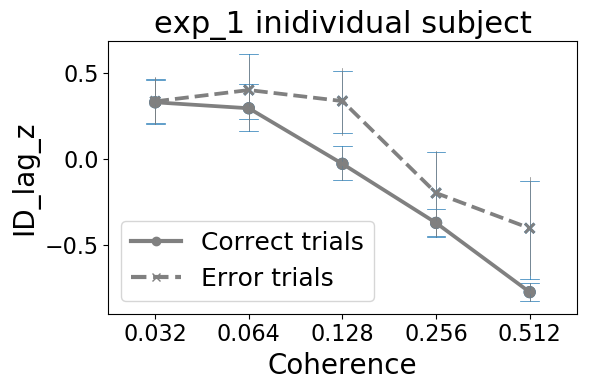

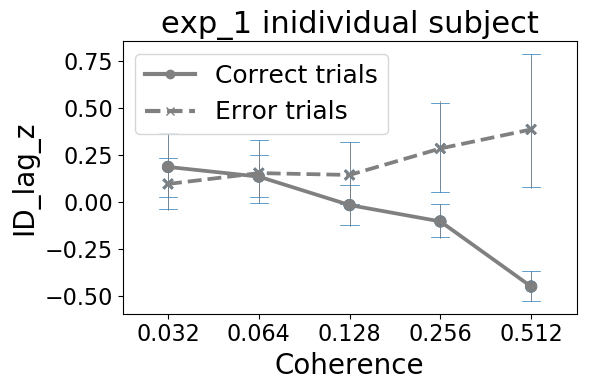

In [22]:
plot_1 = lambda c: plot_var_vs_coherence(c, 'exp_1 inidividual subject', var='ID_lag_z')
choices_1.groupby('subj_id').apply(plot_1)

Next, let's look at Exp 2 ID lag.

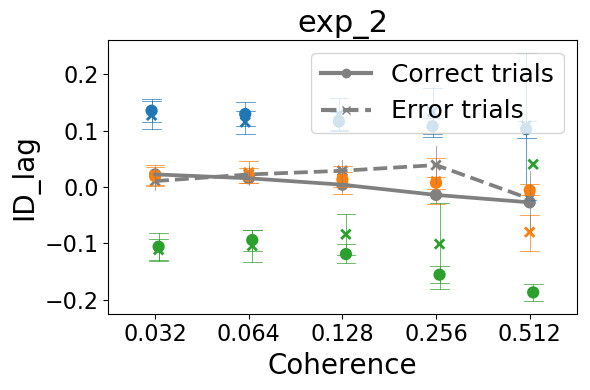

In [17]:
plot_var_vs_coherence(choices_2, exp_2, var='ID_lag')

Here the variability is even higher. The three participants have very different lags, one has positive lag, one has negative lag, and another one's lag is around 0. However, z-score of lag again shows the same pattern for all participants.

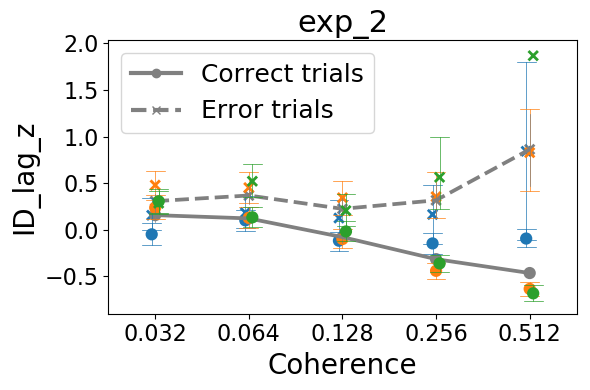

In [23]:
plot_var_vs_coherence(choices_2, exp_2, var='ID_lag_z')

So there still seems to be a decrease in hand-eye lag with coherence (in correct trials), compared to the individual-level baseline.  